## 1. Imports and Configuration

In [69]:
# Core libraries
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# Machine learning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
SAMPLE_RATE = 22050  # Standard sample rate
DURATION = 5.0       # Fixed audio duration in seconds
N_MFCC = 13          # Number of MFCC coefficients

# Paths
DATA_DIR = 'data/raw'
OUTPUT_DIR = 'output'
CLASSES = ['car', 'tram']

print("Libraries loaded successfully!")
print(f"Sample Rate: {SAMPLE_RATE} Hz")
print(f"Audio Duration: {DURATION} seconds")
print(f"Classes: {CLASSES}")

Libraries loaded successfully!
Sample Rate: 22050 Hz
Audio Duration: 5.0 seconds
Classes: ['car', 'tram']


## 2. Data Loading

Load audio files from the `data/raw/car` and `data/raw/tram` folders.

In [70]:
def load_audio_files(data_dir, classes, sr=SAMPLE_RATE):
    """
    Load all audio files from class folders.
    
    Returns:
        audio_data: list of (audio_array, sample_rate, filename)
        labels: list of class labels
    """
    audio_data = []
    labels = []
    
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist!")
            continue
        
        files = [f for f in os.listdir(class_dir) 
                 if f.endswith(('.wav', '.mp3', '.flac', '.ogg', '.m4a'))]
        
        print(f"Loading {len(files)} files from '{class_name}' folder...")
        
        for filename in files:
            filepath = os.path.join(class_dir, filename)
            try:
                # Load audio file
                audio, _ = librosa.load(filepath, sr=sr)
                audio_data.append((audio, sr, filename))
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    return audio_data, labels

# Load the data
audio_data, labels = load_audio_files(DATA_DIR, CLASSES)

print(f"\nTotal samples loaded: {len(audio_data)}")
print(f"Class distribution:")
for cls in CLASSES:
    count = labels.count(cls)
    print(f"  - {cls}: {count} samples")

Loading 1344 files from 'car' folder...
Error loading 663275__audiosophie__car12.wav: 
Error loading 663276__audiosophie__car11.wav: 
Error loading 663277__audiosophie__car10.wav: 
Error loading 663278__audiosophie__car1.wav: 
Error loading 663279__audiosophie__car16.wav: 
Error loading 663280__audiosophie__car15.wav: 
Error loading 663281__audiosophie__car14.wav: 
Error loading 663282__audiosophie__car13.wav: 
Error loading 663283__audiosophie__car18.wav: 
Error loading 663284__audiosophie__car17.wav: 
Error loading 663287__audiosophie__car2.wav: 
Error loading 663288__audiosophie__car8.wav: 
Error loading 663289__audiosophie__car19.wav: 
Error loading 663290__audiosophie__car6.wav: 
Error loading 663291__audiosophie__car20.wav: 
Error loading 663292__audiosophie__car7.wav: 
Error loading 663293__audiosophie__car4.wav: 
Error loading 663294__audiosophie__car5.wav: 
Error loading 663295__audiosophie__car9.wav: 
Error loading 663296__audiosophie__car3.wav: 
Loading 1015 files from 'tram

## 3. Normalization

Apply audio normalization:
1. **Peak normalization**: Scale audio to [-1, 1] range
2. **Pad/Truncate**: Ensure all audio clips are exactly 5 seconds

In [71]:
def normalize_audio(audio):
    """
    Apply peak normalization to audio signal.
    Scales the audio to have maximum amplitude of 1.0
    """
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        return audio / max_val
    return audio

def pad_or_truncate(audio, sr, duration=DURATION):
    """
    Pad with zeros or truncate audio to fixed duration.
    """
    target_length = int(sr * duration)
    
    if len(audio) > target_length:
        # Truncate to target length
        return audio[:target_length]
    elif len(audio) < target_length:
        # Pad with zeros
        padding = target_length - len(audio)
        return np.pad(audio, (0, padding), mode='constant')
    return audio

def preprocess_audio(audio_data):
    """
    Apply normalization and padding to all audio samples.
    """
    processed_audio = []
    
    for audio, sr, filename in audio_data:
        # Step 1: Peak normalization
        audio_norm = normalize_audio(audio)
        
        # Step 2: Pad or truncate to fixed duration
        audio_fixed = pad_or_truncate(audio_norm, sr)
        
        processed_audio.append((audio_fixed, sr, filename))
    
    return processed_audio

# Preprocess all audio
processed_audio = preprocess_audio(audio_data)

print(f"Preprocessing complete!")
print(f"All audio clips normalized and padded/truncated to {DURATION} seconds")
print(f"Sample length: {len(processed_audio[0][0])} samples ({DURATION}s at {SAMPLE_RATE}Hz)")

Preprocessing complete!
All audio clips normalized and padded/truncated to 5.0 seconds
Sample length: 110250 samples (5.0s at 22050Hz)


## 4. Feature Extraction

Extract audio features for classification:
- **MFCCs** (13 coefficients): Captures timbral characteristics
- **Spectral Centroid**: "Brightness" of the sound
- **Zero Crossing Rate (ZCR)**: Noisiness indicator
- **RMS Energy**: Volume/loudness
- **Spectral Rolloff**: Frequency distribution

For each feature, we compute **mean** and **standard deviation** across time frames.

In [72]:
def extract_features(audio, sr, n_mfcc=N_MFCC):
    """
    Extract audio features from a single audio sample.
    
    Returns:
        feature_vector: numpy array of aggregated features
    """
    features = []
    
    # 1. MFCCs (13 coefficients x 2 stats = 26 features)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    features.extend(np.mean(mfccs, axis=1))  # Mean of each MFCC
    features.extend(np.std(mfccs, axis=1))   # Std of each MFCC
    
    # 2. Spectral Centroid (2 features)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features.append(np.mean(spectral_centroid))
    features.append(np.std(spectral_centroid))
    
    # 3. Zero Crossing Rate (2 features)
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features.append(np.mean(zcr))
    features.append(np.std(zcr))
    
    # 4. RMS Energy (2 features)
    rms = librosa.feature.rms(y=audio)[0]
    features.append(np.mean(rms))
    features.append(np.std(rms))
    
    # 5. Spectral Rolloff (2 features)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features.append(np.mean(spectral_rolloff))
    features.append(np.std(spectral_rolloff))
    
    return np.array(features)

def extract_all_features(processed_audio):
    """
    Extract features from all audio samples.
    """
    feature_list = []
    
    for i, (audio, sr, filename) in enumerate(processed_audio):
        features = extract_features(audio, sr)
        feature_list.append(features)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(processed_audio)} files...")
    
    return np.array(feature_list)

# Extract features
print("Extracting features...")
X = extract_all_features(processed_audio)

# Create feature names for reference
feature_names = []
for i in range(N_MFCC):
    feature_names.append(f'mfcc_{i+1}_mean')
for i in range(N_MFCC):
    feature_names.append(f'mfcc_{i+1}_std')
feature_names.extend(['spectral_centroid_mean', 'spectral_centroid_std',
                      'zcr_mean', 'zcr_std',
                      'rms_mean', 'rms_std',
                      'spectral_rolloff_mean', 'spectral_rolloff_std'])

print(f"\nFeature extraction complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features per sample: {len(feature_names)}")

Extracting features...
Processed 10/2339 files...
Processed 20/2339 files...
Processed 30/2339 files...
Processed 40/2339 files...
Processed 50/2339 files...
Processed 60/2339 files...
Processed 70/2339 files...
Processed 80/2339 files...
Processed 90/2339 files...
Processed 100/2339 files...
Processed 110/2339 files...
Processed 120/2339 files...
Processed 130/2339 files...
Processed 140/2339 files...
Processed 150/2339 files...
Processed 160/2339 files...
Processed 170/2339 files...
Processed 180/2339 files...
Processed 190/2339 files...
Processed 200/2339 files...
Processed 210/2339 files...
Processed 220/2339 files...
Processed 230/2339 files...
Processed 240/2339 files...
Processed 250/2339 files...
Processed 260/2339 files...
Processed 270/2339 files...
Processed 280/2339 files...
Processed 290/2339 files...
Processed 300/2339 files...
Processed 310/2339 files...
Processed 320/2339 files...
Processed 330/2339 files...
Processed 340/2339 files...
Processed 350/2339 files...
Proces

## 5. Data Split and Scaling (Disjoint Users)

- Split data by **Freesound users** (not individual samples) to prevent data leakage
- **Train (60%)**: Learn the model
- **Validation (20%)**: Tune hyperparameters
- **Test (20%)**: Final evaluation
- Apply StandardScaler to normalize features (important for SVM!)

In [73]:
# Convert labels to numeric array
label_mapping = {'car': 0, 'tram': 1}
y = np.array([label_mapping[label] for label in labels])
print(f"Labels converted: {len(y)} samples")
print(f"Label mapping: {label_mapping}")

# Extract usernames from filenames for disjoint user splits
# Filename format: ID__username__description.ext
def extract_username(filename):
    """Extract Freesound username from filename."""
    parts = filename.split('__')
    if len(parts) >= 2:
        return parts[1]  # Username is second part
    return filename  # Fallback: use filename as unique identifier

# Get all usernames (audio_data contains tuples of (audio, sr, filename))
usernames = [extract_username(item[2]) for item in audio_data]
unique_users = list(set(usernames))
print(f"\nTotal unique users: {len(unique_users)}")

# Create user-to-indices mapping
user_to_indices = {}
for idx, user in enumerate(usernames):
    if user not in user_to_indices:
        user_to_indices[user] = []
    user_to_indices[user].append(idx)

# Shuffle users and split into train/val/test groups
np.random.seed(42)
shuffled_users = np.random.permutation(unique_users)

# Split: 60% train, 20% validation, 20% test (by users)
n_users = len(shuffled_users)
train_end = int(0.6 * n_users)
val_end = int(0.8 * n_users)

train_users = set(shuffled_users[:train_end])
val_users = set(shuffled_users[train_end:val_end])
test_users = set(shuffled_users[val_end:])

print(f"Train users: {len(train_users)}, Validation users: {len(val_users)}, Test users: {len(test_users)}")

# Get indices for each split
train_indices = [idx for user in train_users for idx in user_to_indices[user]]
val_indices = [idx for user in val_users for idx in user_to_indices[user]]
test_indices = [idx for user in test_users for idx in user_to_indices[user]]

# Create train/val/test splits
X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_val = y[val_indices]
y_test = y[test_indices]

print(f"\nSplit sizes:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

# Check class distribution
print(f"\nClass distribution:")
print(f"Train - Car: {sum(y_train == 0)}, Tram: {sum(y_train == 1)}")
print(f"Validation - Car: {sum(y_val == 0)}, Tram: {sum(y_val == 1)}")
print(f"Test - Car: {sum(y_test == 0)}, Tram: {sum(y_test == 1)}")

# Scale features (fit on train only!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler (fitted on training set only)")

Labels converted: 2339 samples
Label mapping: {'car': 0, 'tram': 1}

Total unique users: 80
Train users: 48, Validation users: 16, Test users: 16

Split sizes:
Train: 1490 samples
Validation: 418 samples
Test: 431 samples

Class distribution:
Train - Car: 825, Tram: 665
Validation - Car: 304, Tram: 114
Test - Car: 195, Tram: 236

Features scaled using StandardScaler (fitted on training set only)


## 6. SVM Training

Train a Support Vector Machine classifier with RBF kernel.
We use the validation set to select optimal hyperparameters (C and gamma), then retrain on train+val.

In [74]:
# Hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

print("Training SVM with hyperparameter tuning using validation set...")
print(f"Parameter grid: {param_grid}")

# Grid search using validation set
best_val_score = 0
best_params = None
best_model = None

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        svm.fit(X_train_scaled, y_train)
        val_score = svm.score(X_val_scaled, y_val)
        
        if val_score > best_val_score:
            best_val_score = val_score
            best_params = {'C': C, 'gamma': gamma}
            best_model = svm

print(f"\nBest parameters: {best_params}")
print(f"Best validation accuracy: {best_val_score:.4f}")

# Retrain best model on train + validation combined
X_train_val = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

final_model = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], random_state=42)
final_model.fit(X_train_val, y_train_val)
print(f"\nFinal model trained on {len(X_train_val)} samples (train + validation)")

Training SVM with hyperparameter tuning using validation set...
Parameter grid: {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.01, 0.1, 1]}

Best parameters: {'C': 1, 'gamma': 'scale'}
Best validation accuracy: 0.9282

Final model trained on 1908 samples (train + validation)


In [75]:
# Save model and scaler as .pkl files
import pickle

# Save the trained SVM model
model_path = os.path.join(OUTPUT_DIR, 'svm_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Model saved to {model_path}")

# Save the scaler (needed for preprocessing new data)
scaler_path = os.path.join(OUTPUT_DIR, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

# Save feature names for reference
feature_names_path = os.path.join(OUTPUT_DIR, 'feature_names.pkl')
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_names, f)
print(f"Feature names saved to {feature_names_path}")

print("\nAll models saved! To load them later:")
print("  with open('output/svm_model.pkl', 'rb') as f:")
print("      model = pickle.load(f)")

Model saved to output\svm_model.pkl
Scaler saved to output\scaler.pkl
Feature names saved to output\feature_names.pkl

All models saved! To load them later:
  with open('output/svm_model.pkl', 'rb') as f:
      model = pickle.load(f)


## 7. Evaluation

Evaluate the trained model on the test set using:
- **Accuracy**: Overall correctness
- **Precision**: How many predicted positives are actually positive
- **Recall**: How many actual positives were correctly identified
- **F1-Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: Detailed breakdown of predictions

In [76]:
# Make predictions on test set
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("="*50)
print("MODEL EVALUATION RESULTS (on held-out test set)")
print("="*50)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Detailed classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=CLASSES))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

MODEL EVALUATION RESULTS (on held-out test set)

Accuracy:  0.9049 (90.49%)
Precision: 0.9081
Recall:    0.9049
F1-Score:  0.9051

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         car       0.86      0.94      0.90       195
        tram       0.95      0.88      0.91       236

    accuracy                           0.90       431
   macro avg       0.90      0.91      0.90       431
weighted avg       0.91      0.90      0.91       431


Confusion Matrix:
[[183  12]
 [ 29 207]]


## 8. Visualizations

Create visualizations for the report:
1. Sample waveforms from each class
2. Sample spectrograms
3. Confusion matrix heatmap
4. Feature importance analysis

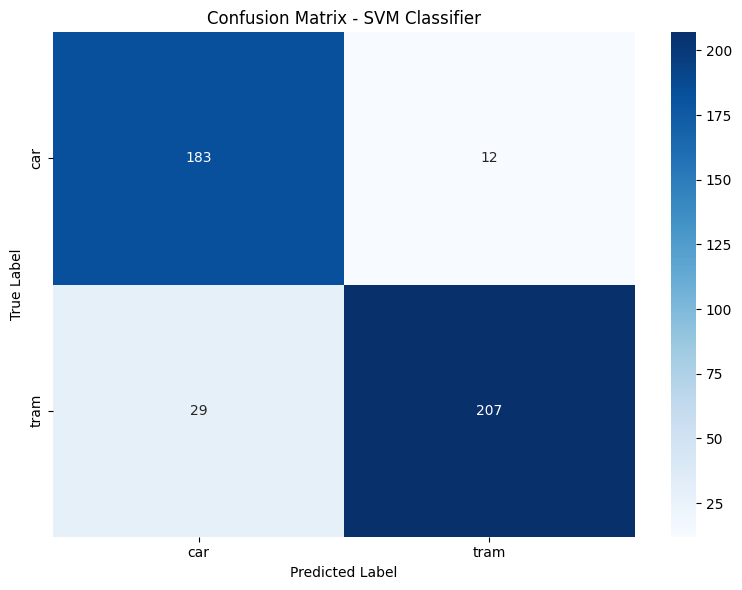

Confusion matrix saved to output/confusion_matrix.png


In [77]:
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

print(f"Confusion matrix saved to {OUTPUT_DIR}/confusion_matrix.png")

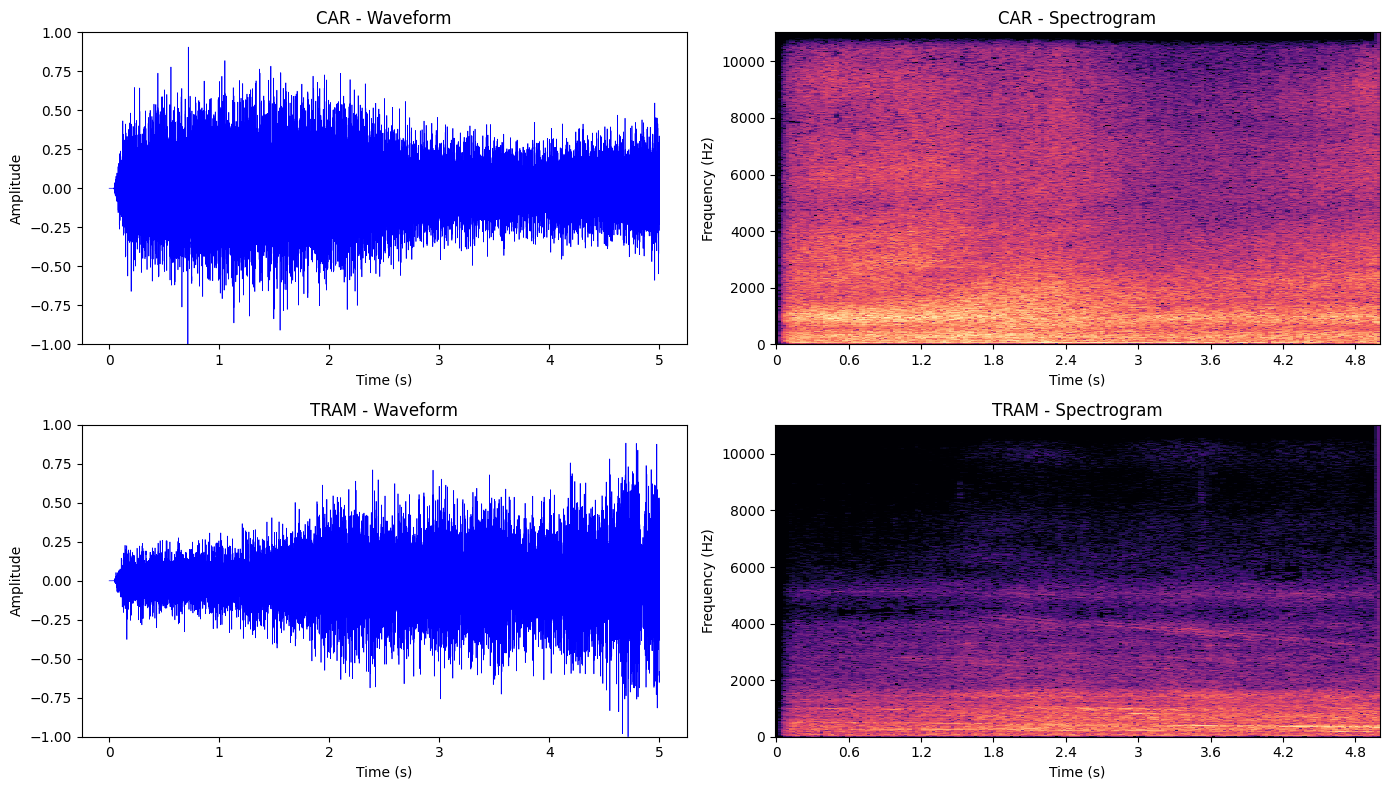

Waveforms and spectrograms saved to output/waveforms_spectrograms.png


In [78]:
# Plot sample waveforms from each class
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for idx, class_name in enumerate(CLASSES):
    # Find first sample of this class
    class_idx = labels.index(class_name)
    audio, sr, filename = processed_audio[class_idx]
    
    # Waveform
    axes[idx, 0].plot(np.linspace(0, DURATION, len(audio)), audio, color='blue', linewidth=0.5)
    axes[idx, 0].set_title(f'{class_name.upper()} - Waveform')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].set_ylim(-1, 1)
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{class_name.upper()} - Spectrogram')
    axes[idx, 1].set_xlabel('Time (s)')
    axes[idx, 1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'waveforms_spectrograms.png'), dpi=150)
plt.show()

print(f"Waveforms and spectrograms saved to {OUTPUT_DIR}/waveforms_spectrograms.png")

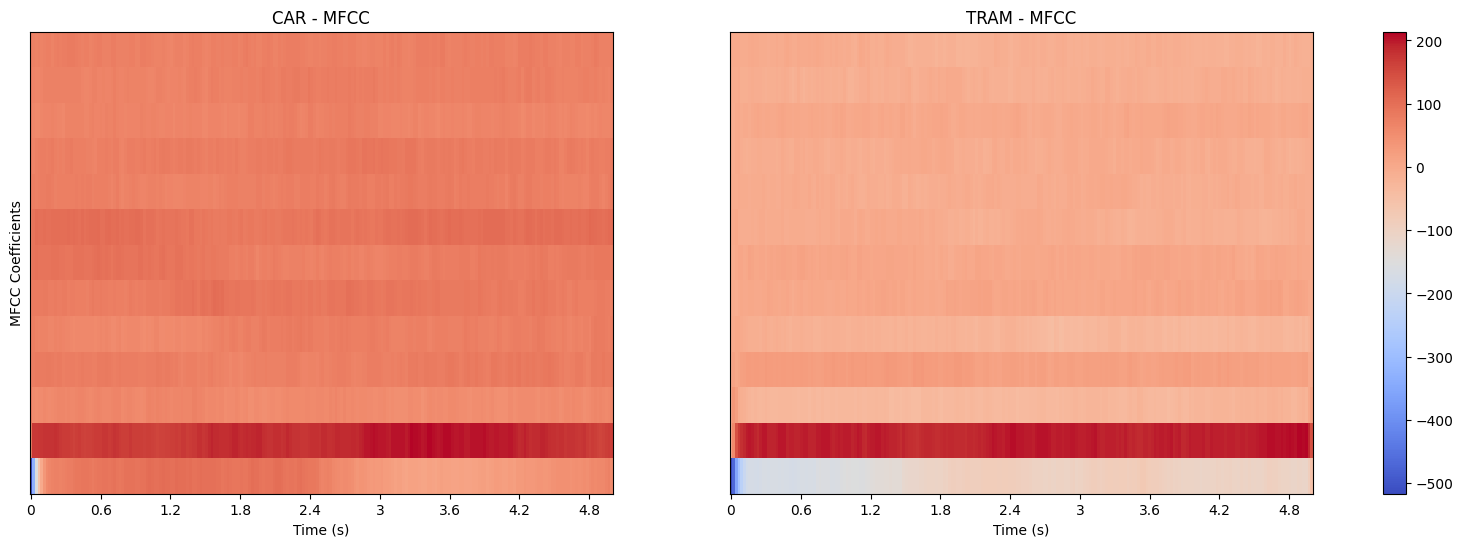

MFCC saved to output/mfcc_plot.png


In [79]:
# MFCC Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for idx, class_name in enumerate(CLASSES):
    #  first sample of this class
    class_idx = labels.index(class_name)
    audio, sr, filename = processed_audio[class_idx]

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Plot MFCC
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axes[idx])
    axes[idx].set_title(f'{class_name.upper()} - MFCC')
    axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('MFCC Coefficients')
    axes[idx].label_outer()

cbar = fig.colorbar(axes[1].collections[0], ax=axes, location='right', 
                    fraction=0.03, pad=0.05)

plt.savefig(os.path.join(OUTPUT_DIR, 'mfcc_plot.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"MFCC saved to {OUTPUT_DIR}/mfcc_plot.png")

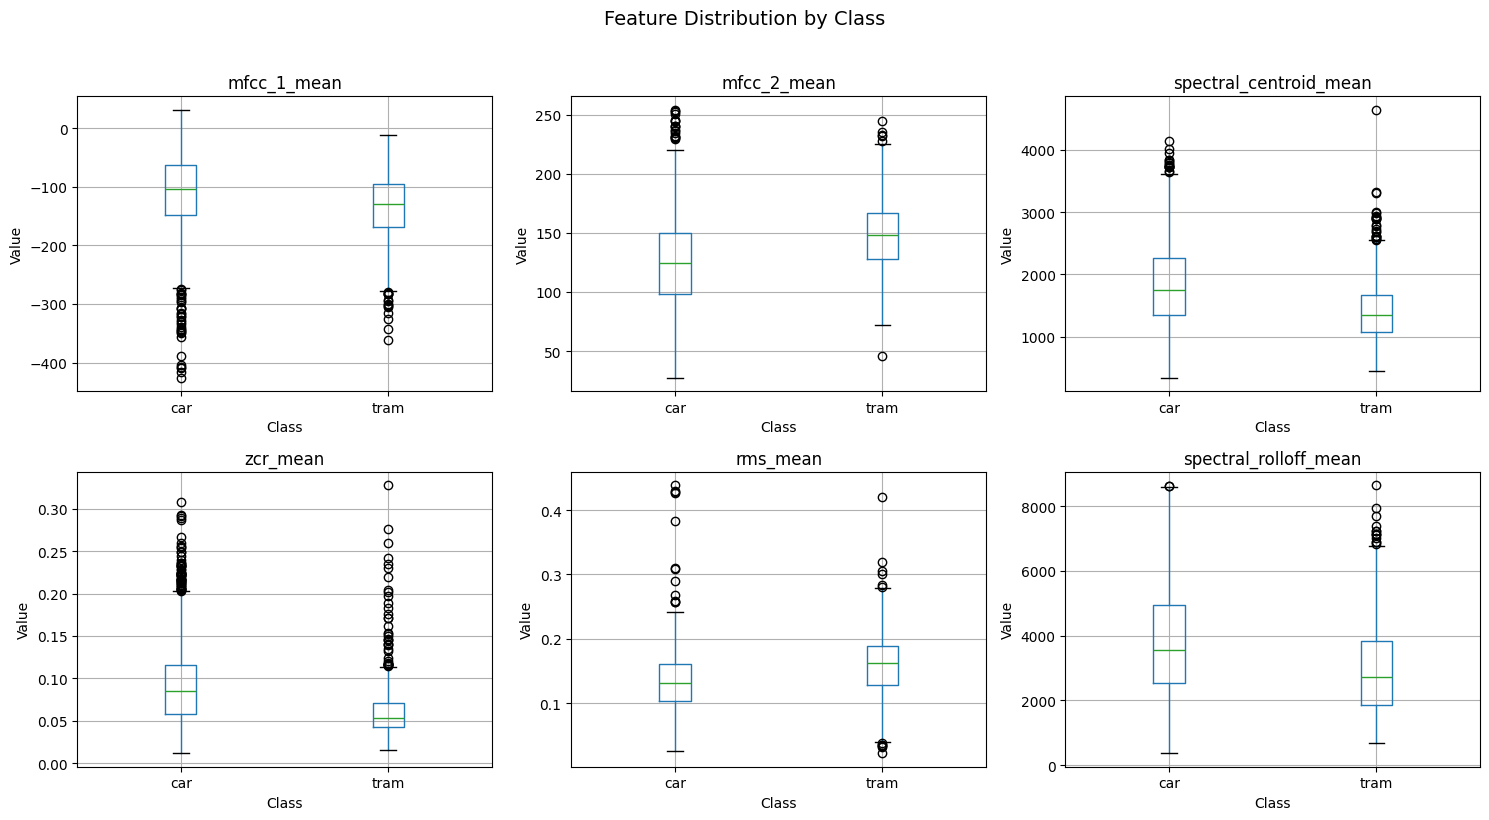

Feature distribution plot saved to output/feature_distribution.png


In [80]:
# Feature statistics comparison between classes
df_features = pd.DataFrame(X, columns=feature_names)
df_features['class'] = labels

# Plot mean feature values per class for key features
key_features = ['mfcc_1_mean', 'mfcc_2_mean', 'spectral_centroid_mean', 
                'zcr_mean', 'rms_mean', 'spectral_rolloff_mean']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    df_features.boxplot(column=feature, by='class', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Value')

plt.suptitle('Feature Distribution by Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_distribution.png'), dpi=150)
plt.show()

print(f"Feature distribution plot saved to {OUTPUT_DIR}/feature_distribution.png")

In [81]:
# Summary statistics
print("="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  - Total samples: {len(audio_data)}")
print(f"  - Car samples: {labels.count('car')}")
print(f"  - Tram samples: {labels.count('tram')}")
print(f"  - Audio duration: {DURATION} seconds")
print(f"  - Sample rate: {SAMPLE_RATE} Hz")

print(f"\nData Split (Disjoint Users):")
print(f"  - Total unique users: {len(unique_users)}")
print(f"  - Train users: {len(train_users)} ({len(X_train)} samples)")
print(f"  - Validation users: {len(val_users)} ({len(X_val)} samples)")
print(f"  - Test users: {len(test_users)} ({len(X_test)} samples)")

print(f"\nFeatures:")
print(f"  - Total features: {len(feature_names)}")
print(f"  - MFCCs: {N_MFCC} coefficients (mean + std)")
print(f"  - Spectral features: centroid, ZCR, RMS, rolloff")

print(f"\nModel:")
print(f"  - Classifier: Support Vector Machine (SVM)")
print(f"  - Kernel: RBF")
print(f"  - Best C: {best_params['C']}")
print(f"  - Best gamma: {best_params['gamma']}")
print(f"  - Validation accuracy: {best_val_score*100:.2f}%")

print(f"\nTest Results:")
print(f"  - Accuracy: {accuracy*100:.2f}%")
print(f"  - Precision: {precision*100:.2f}%")
print(f"  - Recall: {recall*100:.2f}%")
print(f"  - F1-Score: {f1*100:.2f}%")

print("\n" + "="*60)
print("All results saved to the 'output' folder.")
print("="*60)

PROJECT SUMMARY

Dataset:
  - Total samples: 2339
  - Car samples: 1324
  - Tram samples: 1015
  - Audio duration: 5.0 seconds
  - Sample rate: 22050 Hz

Data Split (Disjoint Users):
  - Total unique users: 80
  - Train users: 48 (1490 samples)
  - Validation users: 16 (418 samples)
  - Test users: 16 (431 samples)

Features:
  - Total features: 34
  - MFCCs: 13 coefficients (mean + std)
  - Spectral features: centroid, ZCR, RMS, rolloff

Model:
  - Classifier: Support Vector Machine (SVM)
  - Kernel: RBF
  - Best C: 1
  - Best gamma: scale
  - Validation accuracy: 92.82%

Test Results:
  - Accuracy: 90.49%
  - Precision: 90.81%
  - Recall: 90.49%
  - F1-Score: 90.51%

All results saved to the 'output' folder.


### Test Audio with an unseen recording 

In [82]:
# Load model and scaler

with open('output/svm_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('output/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Test audio path 
test_audio_path = 'car_driving_by_quickly.wav'  
audio, sr = librosa.load(test_audio_path, sr=SAMPLE_RATE)

print(f"Testing audio file: {test_audio_path}")

# Preprocess and feature extraction
audio = normalize_audio(audio)
audio = pad_or_truncate(audio, sr)

features = extract_features(audio, sr)
features = features.reshape(1, -1)  # Reshape for single sample
features_scaled = scaler.transform(features)

# Prediction
prediction = model.predict(features_scaled)[0]
predicted_class = CLASSES[prediction]
print(f"Predicted class: {predicted_class.upper()}")

Testing audio file: car_driving_by_quickly.wav
Predicted class: CAR
